<a href="https://colab.research.google.com/github/guilhermedossantos/TCC_NN_SARIMA/blob/master/Teste_com_sobreajuste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Primeiro teste de uma rede RNN em um SARIMA 

 - Foi gerado no R um processo $SARIMA(1,0,0)\times(1,0,0)$

In [1]:
#### SETUP ####
# Keras
from keras.models import Sequential # modelo
from keras.layers import Dense, SimpleRNN, LSTM, Reshape,Dropout # camadas
from keras.callbacks import EarlyStopping # early stopping
from keras.optimizers import Adam

# scaler
from sklearn.preprocessing import MinMaxScaler

# Importação do arquivo 
from google.colab import files # upload de arquivos da máquina
import pandas_datareader as web # pacote bem interessante que pode valer a pena explorar (para importação de dados de diversar fontes)

# Gerais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats # usado no qq-plot
import plotly.tools as tls # para tentativa de converter mpl to plotly

# Removendo warnings
import warnings
warnings.filterwarnings('ignore') # tem também a opção 'once' para mostrar apenas uma vez

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


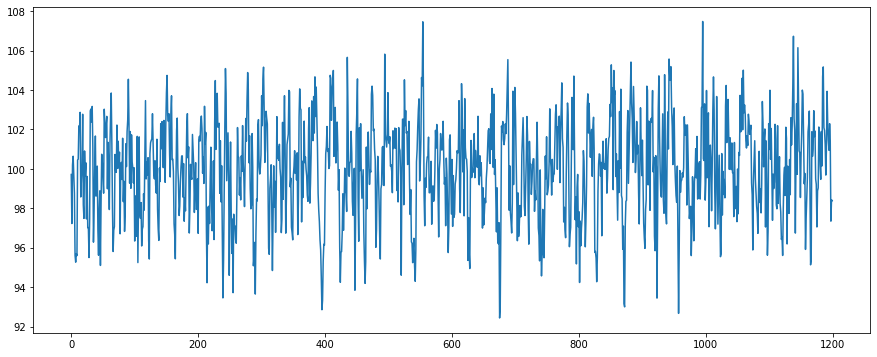

In [2]:
serie = pd.read_csv("https://raw.githubusercontent.com/guilhermedossantos/TCC_NN_SARIMA/master/serie2.csv", index_col=0)
serie = serie
serie = np.array(serie)
#serie
plt.figure(figsize = (15,6))
#plt.plot(serie[1:] - serie[:(len(serie) - 1)])
plt.plot(serie)

#plt.figure()
#plt.plot(serie[:(len(serie)-1)], serie[1:], 'o')


In [0]:
serie_original = serie[:600]

scaler = MinMaxScaler(feature_range=(0,1))
serie = scaler.fit_transform(serie_original)

# Função que transforma a série em uma matriz com k colunas (entradas da rede)
def convert_to_matrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)


k = 60
x, y = convert_to_matrix(serie,k)


In [0]:
x = x.reshape((-1,k,1))
treinox = x[0:(len(x) - 30)]
treinoy = y[0:(len(x) - 30)]
testex = x[(len(x) - 30):]
testey = y[(len(x) - 30):]


In [5]:
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape = (k,1)))#, return_sequences=True))
#model.add(Dropout(0.3)) #, return_sequences = True))
#model.add(LSTM(128, activation='sigmoid', input_shape = (k,1)))
#model.add(LSTM(128, activation='tanh', input_shape = (k,1)))
model.add(Dense(25, activation = "sigmoid"))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mape', 'mae', 'mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                3225      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 69,811
Trainable params: 69,811
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mape', 'mae', 'mse'])
history = model.fit(treinox, treinoy, epochs=300, validation_data=(testex, testey), verbose = 1)

Train on 510 samples, validate on 30 samples
Epoch 1/300
510/510 [==============================] - 2s 3ms/step - loss: 0.0306 - mape: 827944.3125 - mae: 0.1400 - mse: 0.0306 - val_loss: 0.0155 - val_mape: 25.6432 - val_mae: 0.1063 - val_mse: 0.0155
Epoch 2/300
510/510 [==============================] - 1s 2ms/step - loss: 0.0281 - mape: 936098.0000 - mae: 0.1345 - mse: 0.0281 - val_loss: 0.0146 - val_mape: 25.7614 - val_mae: 0.1016 - val_mse: 0.0146
Epoch 3/300
510/510 [==============================] - 1s 2ms/step - loss: 0.0266 - mape: 849973.2500 - mae: 0.1311 - mse: 0.0266 - val_loss: 0.0144 - val_mape: 25.8036 - val_mae: 0.1001 - val_mse: 0.0144
Epoch 4/300
510/510 [==============================] - 1s 2ms/step - loss: 0.0247 - mape: 808381.8125 - mae: 0.1267 - mse: 0.0247 - val_loss: 0.0141 - val_mape: 24.5750 - val_mae: 0.0988 - val_mse: 0.0141
Epoch 5/300
510/510 [==============================] - 1s 2ms/step - loss: 0.0234 - mape: 578870.7500 - mae: 0.1254 - mse: 0.0234 - val

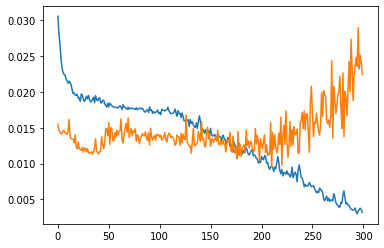

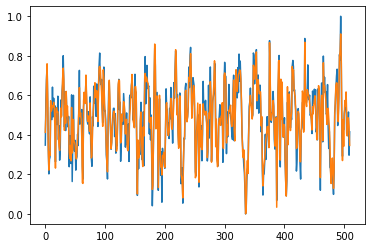

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.figure()
plt.plot(treinoy)
plt.plot(model.predict(treinox))

30/30 [==============================] - 0s 793us/step


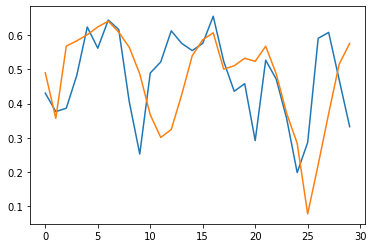

In [8]:
model.evaluate(testex, testey)

plt.plot(testey)
plt.plot(model.predict(testex))

In [9]:
preds = model.predict(testex)
preds_original = scaler.inverse_transform(preds)

y_original = scaler.inverse_transform(testey)

mape = np.mean(abs((y_original - preds_original)/abs(y_original))*100)
mae = np.mean(abs(y_original - preds_original))
mse = np.mean((y_original - preds_original)**2)


print("MAPE com prev. 1 passo a frente: {}%".format(round(mape,3)))
print("MSE com prev. 1 passo a frente: {}".format(round(mse)))
print("MAE com prev. 1 passo a frente: {}".format(round(mae,3)))
print("Vício: {}".format(np.mean(preds_original - y_original).round(3)))

#plt.figure(figsize=(15,6))
#plt.plot(y_original)
#plt.plot(preds_original)


MAPE com prev. 1 passo a frente: 1.644%
MSE com prev. 1 passo a frente: 5.0
MAE com prev. 1 passo a frente: 1.635
Vício: -0.05


In [0]:
#plt.plot(abs((y_original - preds_original)/abs(y_original))*100, 'o')

#np.mean([x for x in abs((y_original - preds_original)/abs(y_original))*100 if x <80])

Previsão vários passos a frente

MAPE: 1.889%
MAE: 1.88
MSE: 6.277
Vício: -0.018


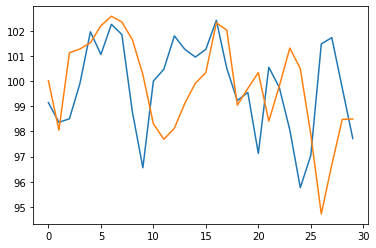

In [11]:
#y_pred = np.zeros(testey.shape)
#for i in range(len(testey)-1):
#  if i == 0:
#    y_pred[0] = model.predict(testex[0].reshape(1,k,1))
#    testex[1] = np.append(testex[0, 1:k], y_pred[0]).reshape((k,1))
#  else:
#    y_pred[i] = model.predict(testex[i].reshape(1,k,1)).reshape((1,))
#    testex[i+1] = np.append(testex[i, 1:k], y_pred[i]).reshape((k,1))

testex2 = testex.copy() #AJEITAR ISSO AQUI PQ N TA PEGANDO O ÚLTIMO ÍNDICE
for i in range(len(testey)-1):
  if i == 0:
    ypred = model.predict(testex2[0].reshape(1,k,1)).reshape(1,)
    testex2[1] = np.append(testex2[0, 1:k], ypred).reshape(k,1)
  else:
    ypred = np.append(ypred, model.predict(testex2[i].reshape(1,k,1)).reshape(1,))  
    testex2[i+1] = np.append(testex2[i, 1:k], ypred[i]).reshape(k,1)

ypred = np.append(ypred, model.predict(testex2[-1].reshape(1,k,1)).reshape(1,))  


preds_original = scaler.inverse_transform(ypred.reshape((-1,1)))

y_original = scaler.inverse_transform(testey)

mape = np.mean(abs((y_original - preds_original)/abs(y_original))*100)
mae = np.mean(abs(y_original - preds_original))
mse = np.mean((y_original - preds_original)**2)

print("MAPE: " + str(round(mape,3)) + "%")
print("MAE: " + str(round(mae,3)))
print("MSE: " + str(round(mse,3)))
print("Vício: {}".format(np.mean(preds_original - y_original).round(3)))

plt.plot(y_original)
plt.plot(preds_original)

#plt.figure()
#plt.plot(ypred)
#plt.plot(testey)

In [0]:
#testex[:,12]
#plt.plot(ypred[:29], preds_original[1:])


In [13]:
y_original

array([[ 99.14263453],
       [ 98.3591234 ],
       [ 98.50123321],
       [ 99.8991726 ],
       [101.95679035],
       [101.05655374],
       [102.25427013],
       [101.84818921],
       [ 98.77850106],
       [ 96.55435222],
       [ 99.99861214],
       [100.47148002],
       [101.79476954],
       [101.26043619],
       [100.95455036],
       [101.26104541],
       [102.41557157],
       [100.4966763 ],
       [ 99.22336204],
       [ 99.54668533],
       [ 97.12312132],
       [100.54648634],
       [ 99.74465467],
       [ 98.05706095],
       [ 95.76318971],
       [ 97.04565541],
       [101.47546153],
       [101.72746305],
       [ 99.71762994],
       [ 97.71748541]])